In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import load_data, SubsetWithAttributes
from utils import TRAINPATH, save_pickle, load_pickle, LANDMARK_DICT, DATAPATH, LANDMARKS_ANGLES_DICT, PICKLEDPATH, BODY_POSE_CONNECTIONS, calc_angle
from plot import *
from pose import poses_for_dataset
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]

mp_pose = mp.solutions.pose

In [3]:
shuffle = False

# Load the data
dataset, dataloader = load_data(path=TRAINPATH, batch_size=None, shuffle=shuffle, subset=False, classify=False)

In [4]:
df = load_pickle(PICKLEDPATH, "pose_landmark_all_df.pickle")
df_vis = load_pickle(PICKLEDPATH, "pose_landmark_vis_df.pickle")
numpy_data = load_pickle(PICKLEDPATH, "pose_landmark_numpy.pickle")
df_world = load_pickle(PICKLEDPATH, "pose_world_landmark_all_df.pickle")
df_vis_world = load_pickle(PICKLEDPATH, "pose_world_landmark_vis_df.pickle")
numpy_data_world = load_pickle(PICKLEDPATH, "pose_world_landmark_numpy.pickle")
labels_drop_na = load_pickle(PICKLEDPATH, "labels_drop_na.pickle")
annotated_images = load_pickle(PICKLEDPATH, "annotated_images.pickle")

In [5]:
df_world.head()

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX,label,quality
0,"[0.5094387531280518, 0.4301232099533081, -0.06...","[0.5527792572975159, 0.40798187255859375, -0.0...","[0.5532554388046265, 0.40830954909324646, -0.0...","[0.5535019636154175, 0.4079565703868866, -0.05...","[0.5451756715774536, 0.4039901793003082, -0.08...","[0.5457608699798584, 0.4046000838279724, -0.08...","[0.5469983816146851, 0.4048534035682678, -0.08...","[0.5569679141044617, 0.3060126006603241, 0.013...","[0.533198356628418, 0.2860211431980133, -0.139...","[0.49014395475387573, 0.39349159598350525, -0....",...,"[0.060842715203762054, 0.34568607807159424, 0....","[0.06854438036680222, 0.33528968691825867, -0....","[-0.2923329770565033, 0.3005911111831665, 0.26...","[-0.31221795082092285, 0.28070342540740967, 0....","[-0.33409351110458374, 0.2945518493652344, 0.2...","[-0.35264378786087036, 0.2712188959121704, 0.0...","[-0.394636332988739, 0.3432268500328064, 0.299...","[-0.42258280515670776, 0.34207311272621155, 0....",0,0
1,"[-0.38985568284988403, 0.45869505405426025, -0...","[-0.4284219443798065, 0.4739674925804138, -0.0...","[-0.42892223596572876, 0.47417712211608887, -0...","[-0.42867037653923035, 0.4746217131614685, -0....","[-0.43183574080467224, 0.4699442684650421, -0....","[-0.4328234791755676, 0.47002044320106506, -0....","[-0.433645099401474, 0.4709497094154358, -0.01...","[-0.4739130735397339, 0.3844611942768097, -0.1...","[-0.4953678250312805, 0.37978747487068176, 0.0...","[-0.3959203362464905, 0.407041072845459, -0.03...",...,"[0.23040509223937988, 0.3137916028499603, -0.0...","[0.221861332654953, 0.31280770897865295, 0.143...","[0.47479891777038574, 0.5971766710281372, -0.0...","[0.47630786895751953, 0.5940971970558167, 0.19...","[0.49703285098075867, 0.629193902015686, -0.02...","[0.5011653900146484, 0.6311691999435425, 0.199...","[0.42076385021209717, 0.6982510685920715, -0.0...","[0.42085811495780945, 0.6906334757804871, 0.15...",0,0
2,"[-0.3550243377685547, 0.48718833923339844, 0.0...","[-0.38596802949905396, 0.5058086514472961, -0....","[-0.3862501382827759, 0.5059595108032227, -0.0...","[-0.38623324036598206, 0.5063908100128174, -0....","[-0.38833102583885193, 0.50474613904953, 0.032...","[-0.389514684677124, 0.5049715638160706, 0.031...","[-0.39029186964035034, 0.5059045553207397, 0.0...","[-0.4384312033653259, 0.42175599932670593, -0....","[-0.4428476095199585, 0.4320095479488373, 0.08...","[-0.3642868399620056, 0.4385015368461609, 0.00...",...,"[0.22138327360153198, 0.38382577896118164, -0....","[0.2864622473716736, -0.32878875732421875, 0.1...","[0.4019528031349182, 0.6882452368736267, 0.049...","[0.552087128162384, -0.5709179043769836, 0.158...","[0.41875696182250977, 0.7203000783920288, 0.04...","[0.5909189581871033, -0.5925405025482178, 0.16...","[0.3707978129386902, 0.8269738554954529, 0.013...","[0.6515375971794128, -0.583726167678833, 0.111...",0,0
3,"[0.22823238372802734, 0.5103627443313599, -0.0...","[0.2718566656112671, 0.5318495631217957, -0.03...","[0.27203115820884705, 0.5324782729148865, -0.0...","[0.27230724692344666, 0.5324369072914124, -0.0...","[0.26743727922439575, 0.5253346562385559, -0.0...","[0.2675960659980774, 0.5260642766952515, -0.06...","[0.2685805857181549, 0.5268241763114929, -0.06...","[0.3687087893486023, 0.49153614044189453, 0.03...","[0.35788482427597046, 0.46314331889152527, -0....","[0.25262805819511414, 0.4797523617744446, -0.0...",...,"[-0.14722219109535217, 0.29361653327941895, 0....","[-0.14378678798675537, 0.34402692317962646, -0...","[-0.38521629571914673, 0.6068304777145386, 0.2...","[-0.39301079511642456, 0.5865709781646729, 0.0...","[-0.40678489208221436, 0.6504248976707458, 0.2...","[-0.41162317991256714, 0.618124783039093, 0.00...","[-0.3168768286705017, 0.7225744724273682, 0.22...","[-0.340908408164978, 0.679251909255981

In [6]:
annotated_images = [img for img in annotated_images if img is not None]

In [7]:
indices = df_world.replace(to_replace='None', value=np.nan).dropna().index
dataset_no_null = SubsetWithAttributes(dataset, indices)

In [8]:
df_world = df_world.replace(to_replace='None', value=np.nan).dropna()
df_world = df_world.reset_index(drop=True)

In [9]:
from data import create_angle_features

create_angle_features(df_world)

df_w1 = df_world.loc[df_world['label'] == 1].copy()
df_w2 = df_world.loc[df_world['label'] == 2].copy()
df_dd = df_world.loc[df_world['label'] == 0].copy()

In [10]:
def plot_3d_keypoints(x, y, z, elev=0, azim=0):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(x, y, z)
    ax.view_init(elev=elev, azim=azim)
    for i,j in BODY_POSE_CONNECTIONS:
        ax.plot([x[i],x[j]], [y[i],y[j]], [z[i],z[j]], color='b')
    plt.show()

In [11]:
def front_leg(plane_x, plane_y, plane_z, left_foot, right_foot):

    plane = np.array([plane_x, plane_y, plane_z])
    
    vect = plane[0:2] - plane[2]
    normal_vect = np.cross(vect[1], vect[0])
    left_foot_angle = np.dot(left_foot, normal_vect)
    right_foot_angle = np.dot(right_foot, normal_vect)
    
    if left_foot_angle > right_foot_angle:
        return 'LEFT'
    else:
        return 'RIGHT'
    
def rename_columns(df, forward="LEFT", backward="RIGHT"):
    new_name = []
    for i in df.columns:
        rep = i.replace(forward, "FORWARD").replace(backward, "BACKWARD")
        new_name.append(rep)

    rename_dict = dict(zip(df.columns, new_name))

    df = df.rename(rename_dict, axis=1)
    
    return df

def warrior_pose_front_back(df_pose: pd.DataFrame):
    
    df_pose['forward'] = df_pose.apply(lambda x : front_leg(x['LEFT_HIP'][0:3], x['RIGHT_HIP'][0:3], x['RIGHT_SHOULDER'][0:3], x['LEFT_FOOT_INDEX'][0:3], x['RIGHT_FOOT_INDEX'][0:3]), axis=1)
    
    df_pose_LEFT = df_pose[df_pose['forward'] == 'LEFT']
    df_pose_RIGHT = df_pose[df_pose['forward'] == 'RIGHT']
    df_pose_LEFT = rename_columns(df_pose_LEFT)
    df_pose_RIGHT = rename_columns(df_pose_RIGHT, forward="RIGHT", backward="LEFT")
    df_corrected = pd.concat([df_pose_LEFT, df_pose_RIGHT], axis=0)
    
    return df_corrected, df_corrected.columns[35:51]

In [12]:
df_w1, WARRIOR_LANDMARKS_ANGLES = warrior_pose_front_back(df_w1)
df_w2, _ = warrior_pose_front_back(df_w2)

In [13]:
def get_angle_confidence_intervals(df_pose: pd.DataFrame, LANDMARKS: list, percent: float = .10) -> dict:
    
    df_pose = df_pose.loc[df_pose['quality']==1]
    num = df_pose.shape[0]
    num_to_take = int(num-num*(1-percent))
    
    valid_angles = {}
    for idx, col in enumerate(LANDMARKS):
        low = df_pose[col].sort_values(ascending=True).reset_index(drop=True)[num_to_take]
        median = df_pose[col].median()
        high = df_pose[col].sort_values(ascending=True).reset_index(drop=True)[num-num_to_take]
        
        valid_angles[col] = [low, median, high]
        
    return valid_angles

In [14]:
dd_angles = get_angle_confidence_intervals(df_dd, LANDMARKS_ANGLES_DICT.keys(), percent = .15)

In [15]:
w1_angles = get_angle_confidence_intervals(df_w1, WARRIOR_LANDMARKS_ANGLES, percent = .15)

In [16]:
w2_angles = get_angle_confidence_intervals(df_w2, WARRIOR_LANDMARKS_ANGLES, percent = .15)

In [17]:
def plot_distribution(df, angles, LANDMARKS):
    fig, ax = plt.subplots(2, 8, figsize=(30, 15))
    sns.set_palette(sns.color_palette("Set1"))
    for idx, col in enumerate(LANDMARKS):
        y = int(idx/8)
        x = idx % 8
        sns.histplot(df, x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
        ax[y, x].vlines(angles[col][0], 0, 200)
        ax[y, x].vlines(angles[col][2], 0, 200)
        ax[y, x].tick_params(axis='x')
        ax[y, x].set_ylim(0,200)
        ax[y, x].set_xlim(0,180)

## Differences Good vs. Bad for Downward Dog?

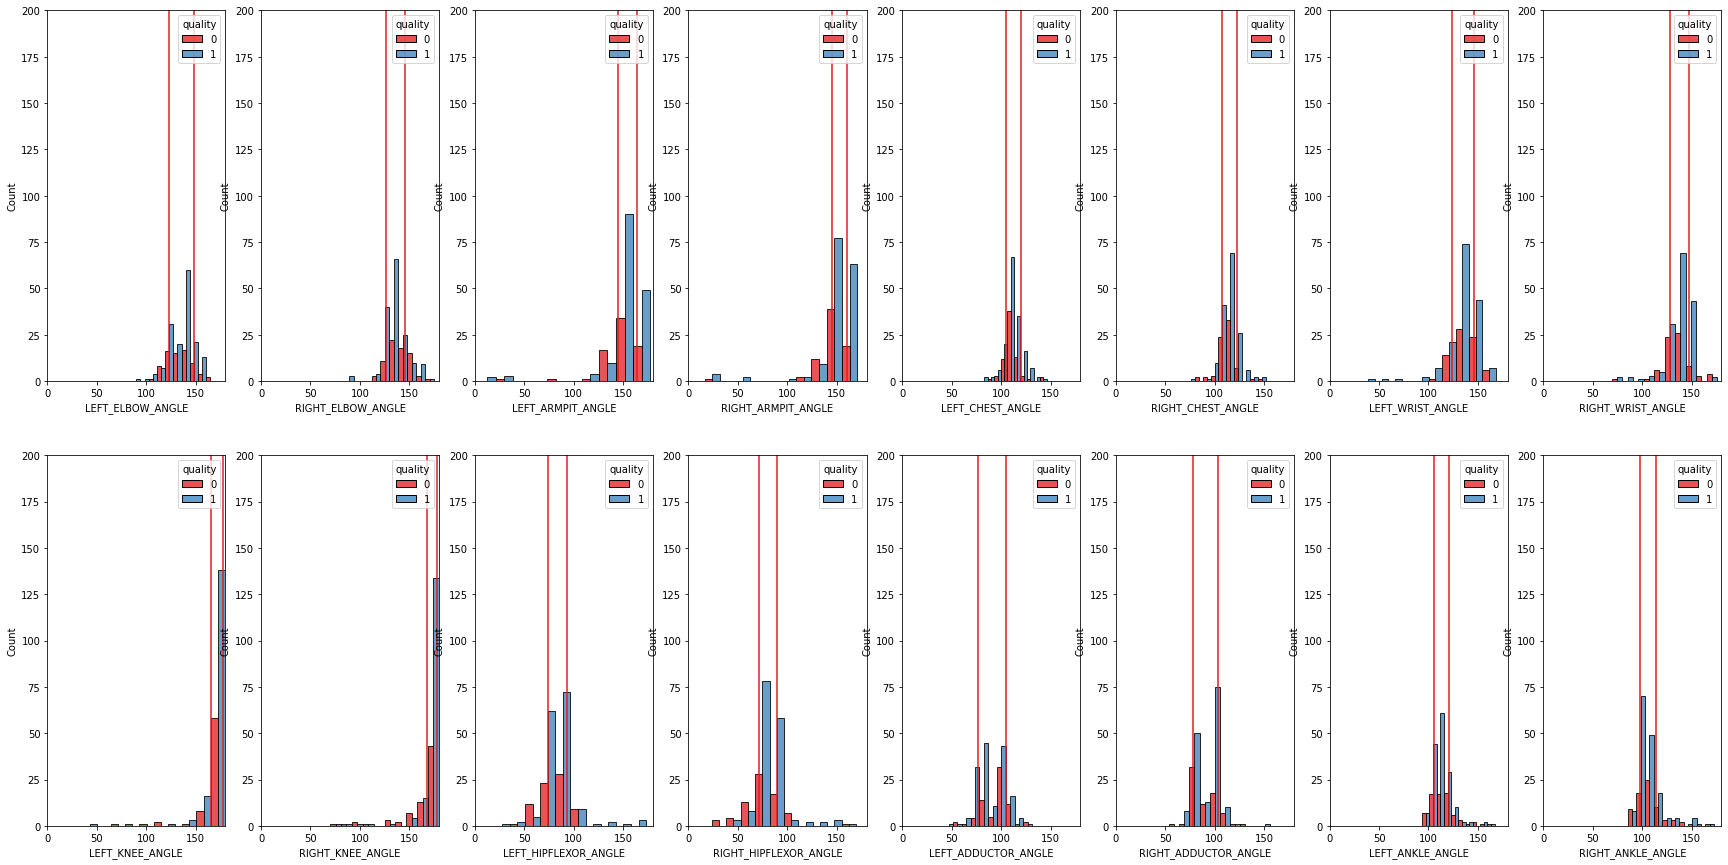

In [18]:
plot_distribution(df_dd, dd_angles, LANDMARKS_ANGLES_DICT.keys())

## Differences Good vs. Bad for Warrior I?

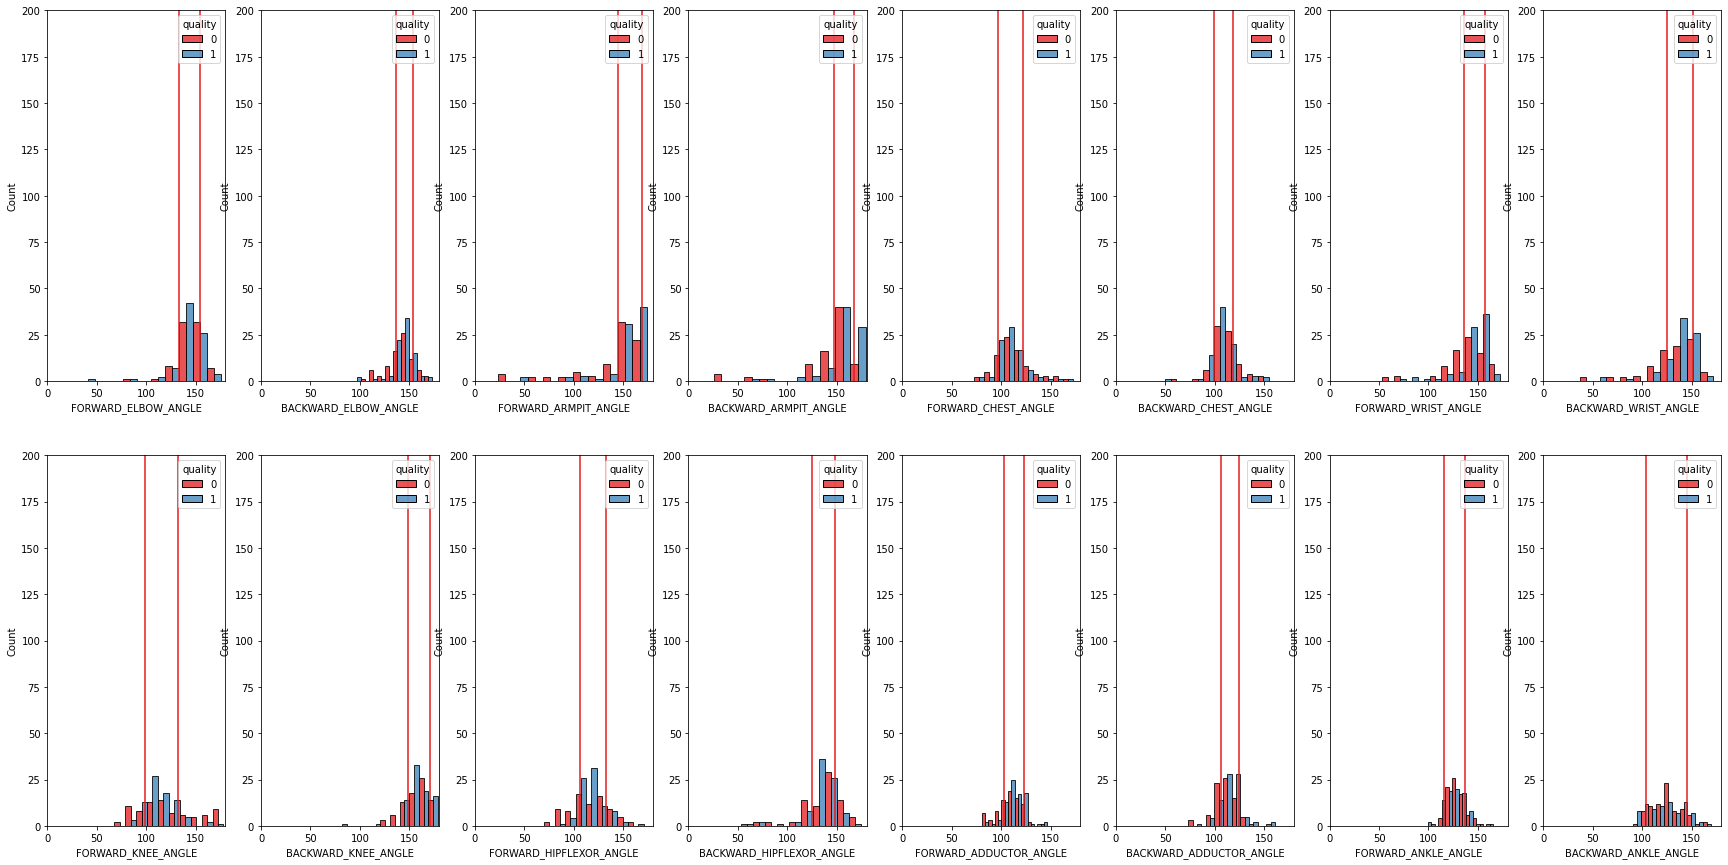

In [19]:
plot_distribution(df_w1, w1_angles, WARRIOR_LANDMARKS_ANGLES)

## Differences Good vs. Bad for Warrioir II?

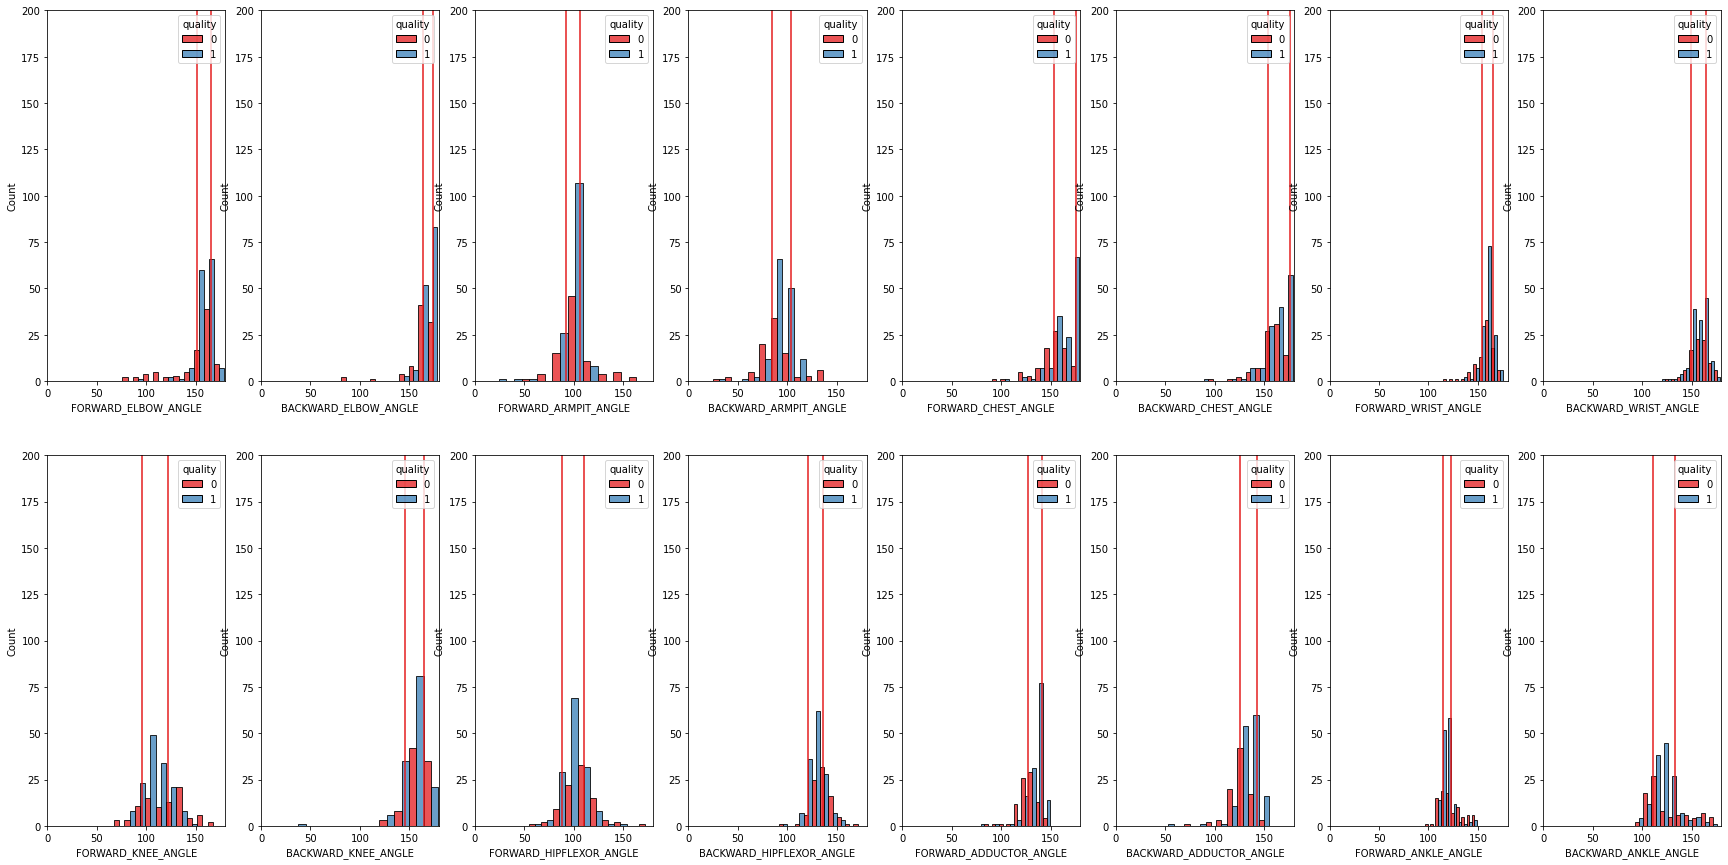

In [20]:
plot_distribution(df_w2, w2_angles, WARRIOR_LANDMARKS_ANGLES)

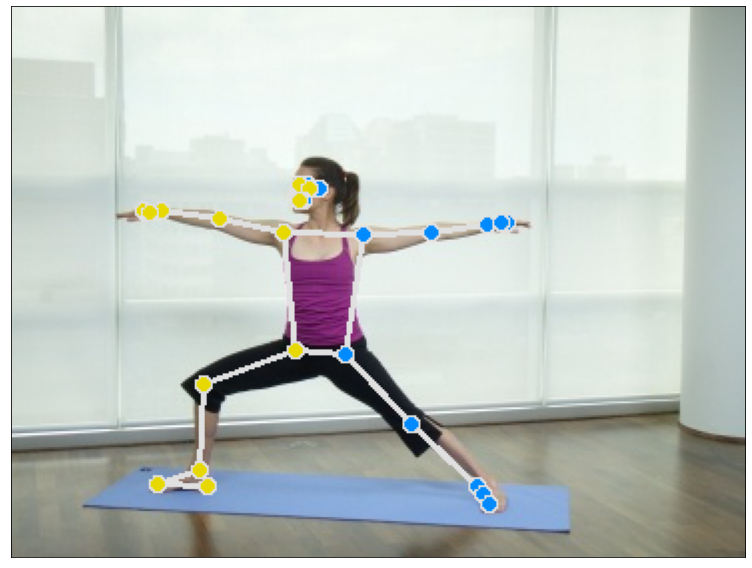

In [21]:
i = 514
plot_image(annotated_images[i])

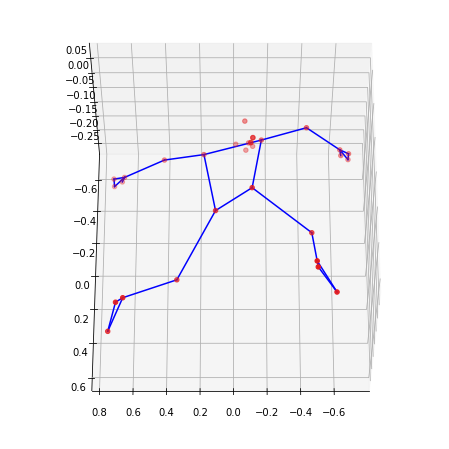

In [22]:
plot_3d_keypoints(numpy_data_world[i].T[0], numpy_data_world[i].T[1],numpy_data_world[i].T[2],60,90)

In [23]:
numpy_data_world[i]

array([[-0.11809544, -0.63310701, -0.1857671 ],
       [-0.10702866, -0.67018139, -0.19486886],
       [-0.10665038, -0.67066061, -0.19405095],
       [-0.10683505, -0.67074817, -0.19357066],
       [-0.11934037, -0.66600138, -0.17346607],
       [-0.11928579, -0.66681892, -0.17448404],
       [-0.11934527, -0.66804326, -0.17380896],
       [-0.01428942, -0.65222722, -0.18937384],
       [-0.06859477, -0.6467191 , -0.10296257],
       [-0.07611106, -0.60557961, -0.18381576],
       [-0.09215706, -0.6014657 , -0.15515462],
       [ 0.17948179, -0.4879736 , -0.13130093],
       [-0.16688144, -0.4995918 , -0.08601528],
       [ 0.42142546, -0.50292033, -0.15993024],
       [-0.43673235, -0.53108758, -0.06053934],
       [ 0.67272949, -0.50204539, -0.22365402],
       [-0.6467036 , -0.53190589, -0.13990554],
       [ 0.73868835, -0.50022566, -0.22881921],
       [-0.70222449, -0.53439075, -0.15556417],
       [ 0.74058908, -0.51436192, -0.26570886],
       [-0.70388472, -0.55552089, -0.189

In [24]:
def front_leg(plane_x, plane_y, plane_z, left_foot, right_foot):

    plane = np.array([plane_x, plane_y, plane_z])
    
    vect = plane[0:2] - plane[2]
    normal_vect = np.cross(vect[1], vect[0])
    left_foot_angle = np.dot(left_foot, normal_vect)
    right_foot_angle = np.dot(right_foot, normal_vect)
    
    return left_foot_angle, right_foot_angle

In [25]:
front_leg(numpy_data_world[i][23], numpy_data_world[i][24], numpy_data_world[i][12], numpy_data_world[i][31], numpy_data_world[i][32])

(0.0024900412331969636, 0.03654807043251248)

In [26]:
LANDMARK_DICT

{0: 'NOSE',
 1: 'LEFT_EYE_INNER',
 2: 'LEFT_EYE',
 3: 'LEFT_EYE_OUTER',
 4: 'RIGHT_EYE_INNER',
 5: 'RIGHT_EYE',
 6: 'RIGHT_EYE_OUTER',
 7: 'LEFT_EAR',
 8: 'RIGHT_EAR',
 9: 'MOUTH_LEFT',
 10: 'MOUTH_RIGHT',
 11: 'LEFT_SHOULDER',
 12: 'RIGHT_SHOULDER',
 13: 'LEFT_ELBOW',
 14: 'RIGHT_ELBOW',
 15: 'LEFT_WRIST',
 16: 'RIGHT_WRIST',
 17: 'LEFT_PINKY',
 18: 'RIGHT_PINKY',
 19: 'LEFT_INDEX',
 20: 'RIGHT_INDEX',
 21: 'LEFT_THUMB',
 22: 'RIGHT_THUMB',
 23: 'LEFT_HIP',
 24: 'RIGHT_HIP',
 25: 'LEFT_KNEE',
 26: 'RIGHT_KNEE',
 27: 'LEFT_ANKLE',
 28: 'RIGHT_ANKLE',
 29: 'LEFT_HEEL',
 30: 'RIGHT_HEEL',
 31: 'LEFT_FOOT_INDEX',
 32: 'RIGHT_FOOT_INDEX'}

### Research into which foot is forward causing problems in right and left knee calculation. Can we change to a foot forward/foot backward distinction

In [27]:
df_w2['forward'] = df_w2.apply(lambda x : front_leg(x['LEFT_HIP'][0:3], x['RIGHT_HIP'][0:3], x['RIGHT_SHOULDER'][0:3], x['LEFT_FOOT_INDEX'][0:3]), axis=1)

KeyError: 'LEFT_HIP'

In [ ]:
df_w2['forward'].head(10)

In [ ]:
i = 169
%matplotlib notebook
plot_3d_keypoints(numpy_data_world[i].T[0], numpy_data_world[i].T[1],numpy_data_world[i].T[2])

In [ ]:
%matplotlib auto
plot_image(annotated_images[i])

We have people facing in different directions with different feet forward and back. How to get a front foot and back foot out of the calculation.

Idea: We given left and right from the pose estimation. With the left and right we should be able to understand which direction our shoulders and body are facing. With this we can create a plane that divides the space and on one side is in front of us and the other side is behind us. Then whichever foot is in which space tells us which foot is forward. 

In [ ]:
plot_image(annotated_images[410])

In [ ]:
# %matplotlib notebook
i = 409
plot_3d_keypoints(numpy_data_world[i].T[0], numpy_data_world[i].T[1],numpy_data_world[i].T[2])

In [ ]:
res = dict((v,k) for k,v in LANDMARK_DICT.items())
plane_points = [res['LEFT_HIP'], res['RIGHT_HIP'],res['RIGHT_SHOULDER']]

Method 1

In [ ]:
plane = np.array([numpy_data_world[i][j] for j in plane_points])

In [ ]:
plane

In [ ]:
np.linalg.det(plane - numpy_data_world[i][res['LEFT_FOOT_INDEX']])

In [ ]:
np.linalg.det(plane - numpy_data_world[i][res['RIGHT_FOOT_INDEX']])

Method 2

In [ ]:
vect = plane[0:2] - plane[2]
np.dot(numpy_data_world[i][res['LEFT_FOOT_INDEX']], np.cross(vect[1], vect[0]))

In [ ]:
np.dot(numpy_data_world[i][res['RIGHT_FOOT_INDEX']], np.cross(vect[1], vect[0]))

In [ ]:
def front_leg(plane_x, plane_y, plane_z, left_foot):

    plane = np.array([plane_x, plane_y, plane_z])
    
    vect = plane[0:2] - plane[2]
    normal_vect = np.cross(vect[1], vect[0])
    left_foot_angle = np.dot(left_foot, normal_vect)
    
    if left_foot_angle >= 0:
        return 'LEFT'
    else:
        return 'RIGHT'

In [ ]:
df_world_warrior = df_world[df_world['label'].isin([1,2])].copy()

In [ ]:
df_world_warrior['forward'] = df_world_warrior.apply(lambda x : front_leg(x['LEFT_HIP'][0:3], x['RIGHT_HIP'][0:3], x['RIGHT_SHOULDER'][0:3], x['LEFT_FOOT_INDEX'][0:3]), axis=1)

In [ ]:
df_world_warrior_LEFT = df_world_warrior[df_world_warrior['forward'] == 'LEFT']
df_world_warrior_RIGHT = df_world_warrior[df_world_warrior['forward'] == 'RIGHT']

In [ ]:
def rename_columns(df, forward="LEFT", backward="RIGHT"):
    new_name = []
    for i in df.columns:
        rep = i.replace(forward, "FORWARD").replace(backward, "BACKWARD")
        new_name.append(rep)

    rename_dict = dict(zip(df.columns, new_name))

    df = df.rename(rename_dict, axis=1)
    
    return df

In [ ]:
df_world_warrior_LEFT = rename_columns(df_world_warrior_LEFT)
df_world_warrior_RIGHT = rename_columns(df_world_warrior_RIGHT, forward="RIGHT", backward="LEFT")

In [ ]:
df_world_warrior = pd.concat([df_world_warrior_LEFT, df_world_warrior_RIGHT], axis=0)

In [ ]:
df_world_warrior.columns[35:51]

In [ ]:
LANDMARKS_ANGLES_DICT.keys()

In [ ]:
# %matplotlib auto
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(df_world_warrior.columns[35:51]):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world_warrior.loc[df_world_warrior['label']==2], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,180)

### Research into bi-modal distribution of angles

Conclusion is that because of the way media pipe does its calculation it sets the center of the body at point (0,0,0). However this means that when we are calculating our 3D angle slight variations in where a joint is will flip the 3D angle sign from positive to negative. For example for images 401 and 403, they look very similar however the left wrist is just barely negative in the x-direction for one while slightly positive in the x-direction for the other. Because of how we calculate the sign of the angle as the dot product between the cross product and our reference vector this small change pushes the dot product a tiny amount and changes the sign of this dot product. 

In this case my solution is to just ignore this "quadrant" calculation that gives us the sign of the angle and just look at the value of the angle from 0 to 180.

Note: This analysis was done while the sign calculation in calc_angle was in use and uncommented.

In [ ]:
df_world[(df_world['LEFT_ELBOW_ANGLE'] < 0) & (df_world['quality']==1) & (df_world['label']==1)]['LEFT_ELBOW_ANGLE']

In [ ]:
df_world[(df_world['LEFT_ELBOW_ANGLE'] > 0) & (df_world['quality']==1) & (df_world['label']==1)]['LEFT_ELBOW_ANGLE']

In [ ]:
vis = np.take(annotated_images,df_world[(df_world['LEFT_ELBOW_ANGLE'] > 0) & (df_world['quality']==1) & (df_world['label']==1)]['LEFT_ELBOW_ANGLE'].index)
vis2 = np.take(annotated_images,df_world[(df_world['LEFT_ELBOW_ANGLE'] < 0) & (df_world['quality']==1) & (df_world['label']==1)]['LEFT_ELBOW_ANGLE'].index)

In [ ]:
plot_image_grid(vis, 5)

In [ ]:
plot_image_grid(vis2, 5)

In [ ]:
%matplotlib notebook
i = 401
plot_3d_keypoints(numpy_data_world[i].T[0], numpy_data_world[i].T[1],numpy_data_world[i].T[2])

In [ ]:
i=403
j=401

In [ ]:
LANDMARKS_ANGLES_DICT['LEFT_ELBOW_ANGLE']

In [ ]:
res = dict((v,k) for k,v in LANDMARK_DICT.items())
angles = [res[i] for i in LANDMARKS_ANGLES_DICT['LEFT_ELBOW_ANGLE']]

In [ ]:
numpy_data_world[i][angles]

In [ ]:
numpy_data_world[j][angles]

In [ ]:
lms = numpy_data_world[i][angles]

ref = [0,1,0]
lm_1 = lms[0]
lm_2 = lms[1]
lm_3 = lms[2]

lm_2_lm_1_vector = lm_1 - lm_2
lm_2_lm_3_vector = lm_3 - lm_2
# calc angle using https://ch.mathworks.com/matlabcentral/answers/501449-angle-betwen-two-3d-vectors-in-the-range-0-360-degree
cross = np.cross(lm_2_lm_3_vector, lm_2_lm_1_vector)
sign = np.sign(np.dot(cross, ref))
if sign == 0:
    raise ValueError('Reference Vector, v1 and v2 are in the same plane!')
c = np.linalg.norm(cross)
angle = np.degrees(np.arctan2(c, np.dot(lm_2_lm_3_vector, lm_2_lm_1_vector)))

In [ ]:
sign

Here we can see the problematic dot product, it is just barely negative. 

In [ ]:
np.dot(cross, ref)

In [ ]:
angle

In [ ]:
c

In [ ]:
np.dot(lm_2_lm_3_vector, lm_2_lm_1_vector)

In [ ]:
plot = np.array([lm_2_lm_3_vector,[0,0,0] ,lm_2_lm_1_vector])
plot_3d_keypoints(plot.T[0], plot.T[1],plot.T[2])

In [ ]:
np.array([lm_2_lm_3_vector, lm_2_lm_1_vector])

In [ ]:
lms = numpy_data_world[j][angles]

ref = [0,1,0]
lm_1 = lms[0]
lm_2 = lms[1]
lm_3 = lms[2]

lm_2_lm_1_vector = lm_1 - lm_2
lm_2_lm_3_vector = lm_3 - lm_2
# calc angle using https://ch.mathworks.com/matlabcentral/answers/501449-angle-betwen-two-3d-vectors-in-the-range-0-360-degree
cross = np.cross(lm_2_lm_3_vector, lm_2_lm_1_vector)
sign = np.sign(np.dot(cross, ref))
if sign == 0:
    raise ValueError('Reference Vector, v1 and v2 are in the same plane!')
c = np.linalg.norm(cross)
angle = np.degrees(np.arctan2(c, np.dot(lm_2_lm_3_vector, lm_2_lm_1_vector)))

In [ ]:
plot = np.array([lm_2_lm_3_vector,[0,0,0] ,lm_2_lm_1_vector])
plot_3d_keypoints(plot.T[0], plot.T[1],plot.T[2])

Here we can see the problematic dot product. It is just barely positive. 

In [ ]:
np.dot(cross, ref)

In [ ]:
sign

In [ ]:
c

In [ ]:
np.dot(lm_2_lm_3_vector, lm_2_lm_1_vector)

In [ ]:
angle

In [ ]:
def plot_3d_keypoints(x, y, z):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(x, y, z)
    for i,j in BODY_POSE_CONNECTIONS:
        ax.plot([x[i],x[j]], [y[i],y[j]], [z[i],z[j]], color='b')
    plt.show()

In [ ]:
plot_image_grid(annotated_images[380:390], 10)

In [ ]:
i = 56
plot_3d_keypoints(numpy_data_world[i].T[0], numpy_data_world[i].T[1],numpy_data_world[i].T[2])

In [28]:
# assuming already normalized

def calc_2d_angles(vec_2d):
    return np.degrees(np.arctan2(vec_2d[1], vec_2d[0]))

def calc_xyz_angles(vec):
    xy_points = vec[0:2]
    yz_points = vec[1:3]
    
    xy_angle = calc_2d_angles(xy_points)
    yz_angle = calc_2d_angles(yz_points)
    
    return xy_angle, yz_angle

def calc_xyz_dist(vec):
    xy_points = vec[0:2]
    yz_points = vec[1:3]
    
    xy_dist = np.linalg.norm(xy_points, axis=0)
    yz_dist = np.linalg.norm(yz_points, axis=0)
    
    return xy_dist, yz_dist

def calc_xyz_points(xy_angle, xy_dist, yz_angle, yz_dist):
    x, y1 = calc_2d_points(xy_angle, xy_dist)
    y2, z = calc_2d_points(yz_angle, yz_dist)
    
    return x, y1, z
    
def calc_2d_points(angle, dist):
    a = dist * np.cos(np.radians(angle))
    b = dist * np.sin(np.radians(angle))
    return a, b

In [29]:
%matplotlib notebook

In [30]:
def compare_two_figures(length_fig_idx, angle_fig_idx, df, annotated_images, plot=True):
    RIGHT_HIP = 24
    
    #normalize based on right hip
    length_fig = df[length_fig_idx] - np.tile(df[length_fig_idx][RIGHT_HIP], (df[length_fig_idx].shape[0],1))
    angle_fig = df[angle_fig_idx] - np.tile(df[angle_fig_idx][RIGHT_HIP], (df[angle_fig_idx].shape[0],1))
    
    plot_image_grid([annotated_images[length_fig_idx], annotated_images[angle_fig_idx]], 2)
    
    xy_dist, yz_dist = calc_xyz_dist(length_fig.T)
    xy_angle, yz_angle = calc_xyz_angles(angle_fig.T)
    
    px, py, pz = calc_xyz_points(xy_angle, xy_dist, yz_angle, yz_dist)
    lx, ly, lz = length_fig.T[0], length_fig.T[1], length_fig.T[2]
    angx, angy, angz = angle_fig.T[0], angle_fig.T[1], angle_fig.T[2]
    
    if plot:
        fig = plt.figure()
        ax = plt.axes(projection="3d")
        ax.scatter3D(px, py, pz)
        ax.scatter3D(lx, ly, lz)
        ax.scatter3D(angx, angy, angz)
        #ax.plot(points[0],points[1],points[2],color = 'g')
        for i,j in BODY_POSE_CONNECTIONS:
            ax.plot([px[i],px[j]], [py[i],py[j]], [pz[i],pz[j]], color='r')
            ax.plot([lx[i],lx[j]], [ly[i],ly[j]], [lz[i],lz[j]], color='g')
            ax.plot([angx[i],angx[j]], [angy[i],angy[j]], [angz[i],angz[j]], color='b')
        plt.show()

<IPython.core.display.Javascript object>


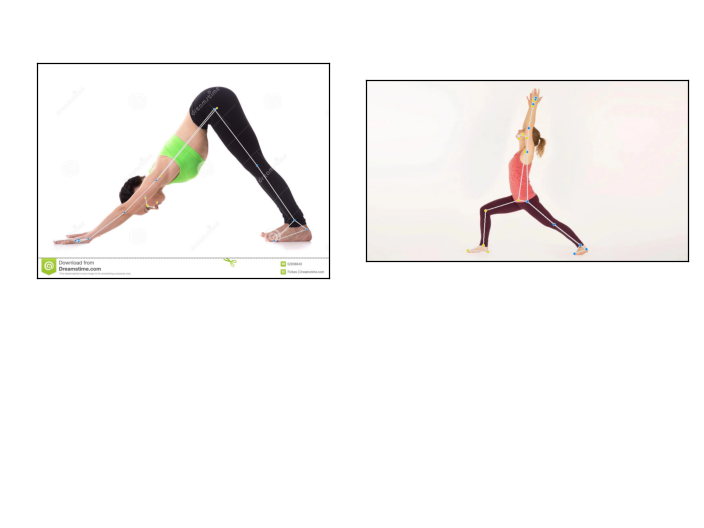

<IPython.core.display.Javascript object>


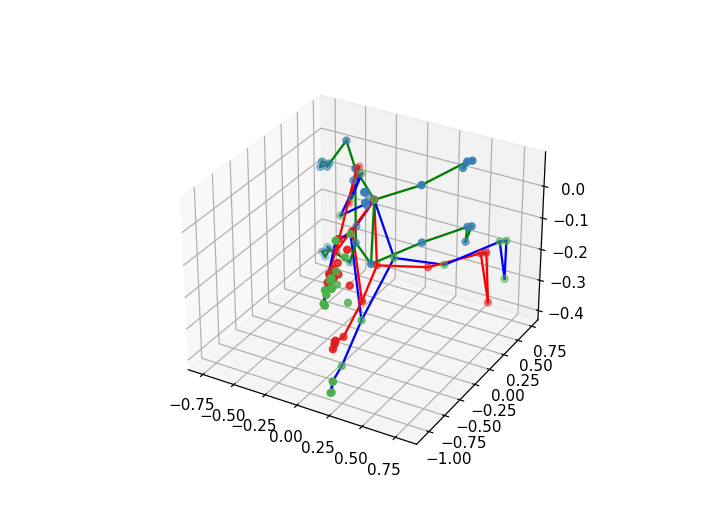

In [34]:
compare_two_figures(310, 400, numpy_data_world, annotated_images)